Fourier解析まとめ (2023/02/26)

目次
- **Fourier級数展開** (Fourier series expansion)
  - $x(t) = \frac{a_0}{2} + \sum_{k=1}^{\infty} \left( a_k \cos{\frac{2\pi kt}{T}} + b_k \sin{\frac{2\pi kt}{T}} \right)$
  - ex. 矩形波のFourier級数展開
- **複素Fourier級数展開**
  - $x(t) = \sum_{k=-\infty}^{\infty} c_k e^{i\frac{2\pi k}{T}t}$
  - ex. 矩形波の複素Fourier級数展開
- **Fourier変換** (Fourier transform; FT)
  - $\hat{x}(f) = \int_\mathbb{R} x(t) e^{-2\pi ift} dt$
  - **離散時間Fourier変換** (discrete-time FT; DTFT)
    - $\hat{x}(f) = \sum_{n=-\infty}^{\infty} x[n] e^{-2\pi ifn}$
  - **離散Fourier変換** (discrete FT; DFT)
    - $\hat{x}[k] = \sum_{n=0}^{N-1} x[n] e^{-i\frac{2\pi k}{N}n}$
  - ex. 矩形波のDFT
  - ライブラリによるDFT
- **短時間Fourier変換** (short-time Fourier transform; STFT)

参考
- 非線形信号解析（CS専攻2022年度講義）
- [MathWorks](https://jp.mathworks.com/discovery/fourier-transform.html)

TODO
- 数学的背景としてFT/DTFTの話は入れておきたいが，ぶっちゃけ信号処理をやる上ではFSからいきなりDFTに入ったほうが近道ではある．どうしよう．
- 早い段階で実装したほうが理解しやすいが，実質DFTなのでDFTを説明してからのほうが良い？
- 前提として連続時間信号・離散時間信号の話をすべき？
- 追加項目
  - サンプリング定理
  - STFT

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Fourier級数展開 Fourier series expansion

時刻 $t$ に対する信号 $x(t): \mathbb{R} \to \mathbb{R}$ が周期Tの周期関数であるとき，次のような級数に展開できる．
$$
x(t) = \frac{a_0}{2} + \sum_{k=1}^{\infty} \left( a_k \cos{\frac{2\pi kt}{T}} + b_k \sin{\frac{2\pi kt}{T}} \right) \\
a_k = \frac{2}{T} \int_0^T {x(t) \cos{\frac{2\pi kt}{T}} dt} \\
b_k = \frac{2}{T} \int_0^T {x(t) \sin{\frac{2\pi kt}{T}} dt}
$$

- Fourier係数 $a_k, b_k$
  - 直流成分 (direct current; DC)
    - $\frac{a_0}{2} = \frac{1}{T} \int_0^T {x(t) dt}$
    - 信号の平均値．
  - 交流成分 (Alaternating current; AC) $k \ge 1$
    - $a_k \cos{\frac{2\pi kt}{T}}$
    - $b_k \sin{\frac{2\pi kt}{T}}$
- ちなみに，被積分関数も周期 $T$ の周期関数なので，積分区間は長さが $T$ であれば $t \in [0, T]$ に限らずどこでも良い．

### ex. 矩形波のFourier級数展開
※積分は数値積分を行う．実質的に後述のDFTと同じこと．

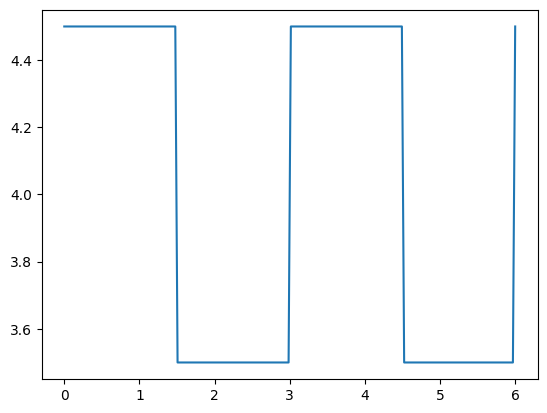

In [13]:
# 周期Tの矩形波を生成
T = 3
t = np.linspace(0, T*2, 200)    # 2周期分の時間を用意
DC = 4.0                        # 直流成分 a0/2
x = (t%T < T/2) - 0.5 + DC      # 矩形波＋直流成分
plt.plot(t, x)

DC: a0/2 = 4.02
a1 = 0.05, b1 = 0.64
a2 = 0.04, b2 = -0.00
a3 = 0.05, b3 = 0.21
a4 = 0.04, b4 = -0.00
a5 = 0.05, b5 = 0.12
a6 = 0.04, b6 = -0.00
a7 = 0.05, b7 = 0.09
a8 = 0.04, b8 = -0.01
a9 = 0.05, b9 = 0.06


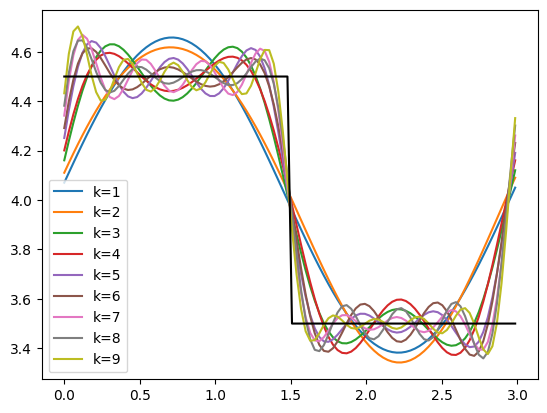

In [14]:
# 積分 ∫xdt の代わりに数値積分 ΣxΔt を行う．以下の変数TsはそのΔtであり，標本化周期とも言う．
Ts = t[1] - t[0]

# 直流成分
a0 = 2/T * sum(x[t<T] * Ts)
x_series = a0 / 2
print(f"DC: a0/2 = {a0/2:.2f}")

# 交流成分
for k in range(1, 10):
    ak = 2/T * (x[t<T] @ np.cos(2*np.pi*k*t[t<T]/T) * Ts)
    bk = 2/T * (x[t<T] @ np.sin(2*np.pi*k*t[t<T]/T) * Ts)
    x_series += ak * np.cos(2*np.pi*k*t[t<T]/T)
    x_series += bk * np.sin(2*np.pi*k*t[t<T]/T)
    print(f"a{k} = {ak:.2f}, b{k} = {bk:.2f}")
    plt.plot(t[t<T], x_series, label=f"k={k}")

# 元の矩形波（黒）
plt.plot(t[t<T], x[t<T], c="k")
plt.legend()

# 複素Fourier級数展開

時刻 $t$ に対する連続信号 $x(t): \mathbb{R} \to \mathbb{C}$ が周期Tの周期関数であるとき，次のような級数に展開できる．
$$
x(t) = \sum_{k=-\infty}^{\infty} c_k e^{i\frac{2\pi k}{T}t} \\
c_k = \frac{1}{T} \int_{0}^{T} {x(t) e^{-i\frac{2\pi k}{T}t} dt}
$$

前述の（実）Fourier級数展開を複素数信号に拡張したもの．複素数の範囲で考えると，次の関係を用いて変形することで上式のように簡潔に表現できる．
- $\exp{(\pm z)} = \cos{z} \pm i\sin{z}$ より
  - $\cos{z} = \frac{\exp(iz)+\exp(-iz)}{2}$
  - $\sin{z} = \frac{\exp(iz)-\exp(-iz)}{2}$

## ex. 矩形波の複素Fourier級数展開

c0 = 4.020+0.000j
c1 = 0.025-0.318j
c-1 = 0.025+0.318j
c2 = 0.020+0.001j
c-2 = 0.020-0.001j
c3 = 0.025-0.105j
c-3 = 0.025+0.105j
c4 = 0.020+0.001j
c-4 = 0.020-0.001j
c5 = 0.025-0.062j
c-5 = 0.025+0.062j
c6 = 0.020+0.002j
c-6 = 0.020-0.002j
c7 = 0.025-0.043j
c-7 = 0.025+0.043j
c8 = 0.020+0.003j
c-8 = 0.020-0.003j
c9 = 0.025-0.032j
c-9 = 0.025+0.032j


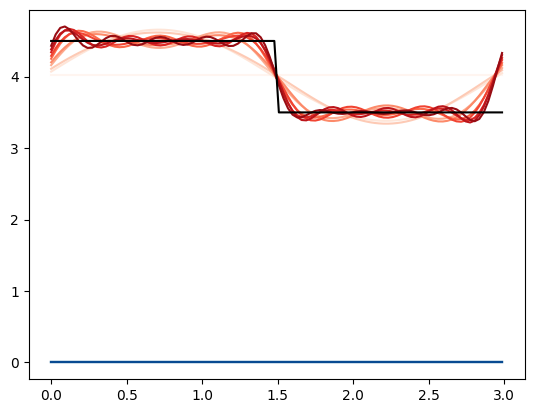

In [39]:
x_series = 0
for k in range(10):
    for k in ([k] if k == 0 else [k, -k]):
        ck = 1/T * (x[t<T] @ np.exp(-2j*np.pi*k*t[t<T]/T) * Ts)
        x_series += ck * np.exp(2j*np.pi*k*t[t<T]/T)
        print(f"c{k} = {ck:.3f}")
    # 実部を赤，虚部を青でプロット．虚部は±kで相殺される．
    plt.plot(t[t<T], x_series.real, c=plt.cm.Reds(abs(k)/10))
    plt.plot(t[t<T], x_series.imag, c=plt.cm.Blues(abs(k)/10))
plt.plot(t[t<T], x[t<T], c="k")

# Fourier変換 Fourier transform; FT

複素Fourier係数 $c_k$ は，$x(t)$ が1周する波の周波数 $1/T$ の $k$ 倍の周波数 $f = k/T$ の成分の大きさを表している．  
Fourier変換では，Fourier級数展開を信号の周波数分解と解釈して分析する．

複素Fourier係数 $c_k$ の式から，（信号全体について考えて）積分区間を実数全体とし，周波数の定義域も $k$ による離散的な値のみならず連続的に考えると
- Fourier変換 Fourier transform; FT
  $$
  \hat{x}(f) = \int_\mathbb{R} x(t) e^{-2\pi ift} dt
  $$
  - 周波数について考える意味で変数を $f$ としているが，角周波数 $\omega=2\pi f$ 等でも良い．
  - 連続的に考えているので $k$ はやや不適かも．
- 逆Fourier変換 inverse Fourier transform; IFT
  $$
  x(t) = \int_\mathbb{R} \hat{x}(f) e^{2\pi ift} df
  $$
- 条件：$x(t)$ は可積分である必要がある．すなわち
  $$
  \int_\mathbb{R} |x(t)| dt < \infty.
  $$

## 離散時間Fourier変換 discrete-time Fourier transform; DTFT

連続信号 $x(t)$ ではなく，離散信号 $x[n]$ を対象とする．積分は総和になるが，微小量 $dt$ （⇔サンプリング周期 $T_s$）は掛けないことに注意．
$$
\hat{x}(f) = \sum_{n=-\infty}^{\infty} x[n] e^{-2\pi ifn}
$$

## 離散Fourier変換 discrete Fourier transform; DFT

区間も無限（実数全体）でなく有限（$N$ 時刻）とすれば，コンピュータ上で現実的な信号の処理ができる．周波数も離散的に扱うので，明示的にインデックス $k$ を用いて $\hat{x}[k]$ と表す．
$$
\hat{x}[k] = \sum_{n=0}^{N-1} x[n] e^{-i\frac{2\pi k}{N}n} \\
(k = 0, 1, ..., N-1)
$$

- ~~実数全体に拡張した意味ねえじゃん．~~  
  - まあね．信号処理をやる上では有限区間で問題ありません．
  - 本家Fourier変換は数学的背景として確認しておきましょう．
- さっき書いてたプログラムとは違うの？
  - 本質的には同じですが，微小量 $dt$（⇔サンプリング周期 $T_s$）を掛けません．そのためDFT後の値は「単位時間あたりの」振幅の大きさになります（割とどうでもいい）．
  - また，周期とか気にせず任意の区間について適用できます．
- （補足）周波数 $f_k$ とインデックス $k$，サンプリング周波数 $f_s$ の関係
  $$
  f_k = \frac{k}{T} = \frac{k}{N T_s} = \frac{k f_s}{N}
  $$

## ex. 矩形波のDFT

(-2.0, 5.0)

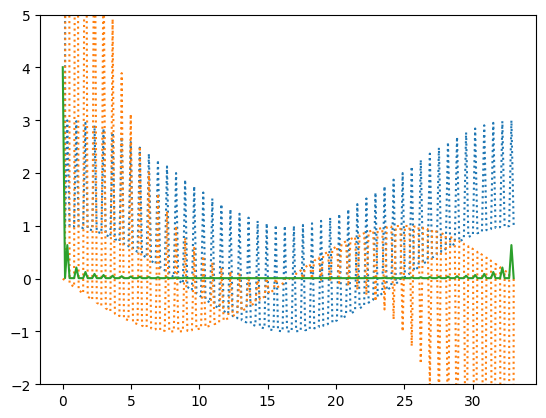

In [53]:
# 信号全体に対してDFTを行う．
N = len(x)
k = np.r_[:N]   # [0, 1, ..., N-1]
n = np.c_[:N]   # [[0], [1], ..., [N-1]]
X = x @ np.exp(2j*np.pi*k*n/N)

# 振幅に変換
A = np.abs(X) / (N / 2)
A[0] /= 2

f = k / (N*Ts)
plt.plot(f, X.real, ":")
plt.plot(f, X.imag, ":")
plt.plot(f, A)
plt.ylim(-2, 5)

## ライブラリによるDFT

(-2.0, 5.0)

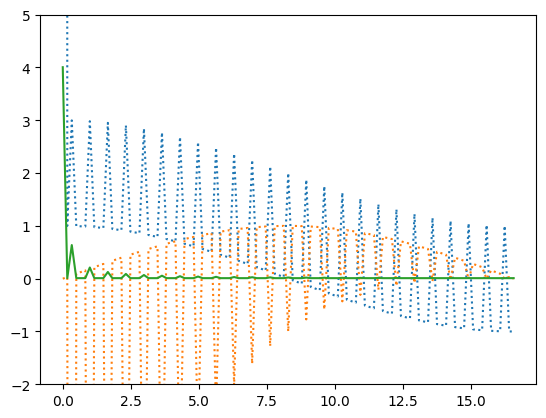

In [52]:
f = np.fft.rfftfreq(N, Ts)
X = np.fft.rfft(x)
A = np.abs(X) / (N / 2)
A[0] /= 2
plt.plot(f, X.real, ":")
plt.plot(f, X.imag, ":")
plt.plot(f, A)
plt.ylim(-2, 5)